In [4]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import json
import copy
import torch.nn as nn
from typing import Any, Callable, Literal, TypeVar, overload
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
with open('./data/dataset.json', 'r') as file:
    dataset_raw = json.load(file)

dataset = []
for k1, v1 in dataset_raw.items():
    for k2, v2 in v1.items():
        dataset += [v2_item[1] for v2_item in v2] 

data_tensor = torch.tensor(dataset, dtype=torch.float32)
train_data, test_data = train_test_split(data_tensor, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.67, random_state=42)

print("Train shape:", train_data.shape)
print("Val shape:", val_data.shape)
print("Test shape:", test_data.shape)

Train shape: torch.Size([1078, 896])
Val shape: torch.Size([152, 896])
Test shape: torch.Size([310, 896])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, l1_lambda=0): # 1e-4
        super(SparseAutoencoder, self).__init__()
        self.l1_lambda = l1_lambda
        self.mse_loss_fn = nn.MSELoss()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )

        self.W_dec = nn.Parameter(
            torch.nn.init.kaiming_uniform_(
                torch.empty(
                    hidden_dim, input_dim
                )
            )
        )

        self.b_dec = nn.Parameter(
            torch.zeros(input_dim)
        )

    def forward(self, x):
        x = x - self.b_dec
        z = self.encoder(x)
        x_hat = z @ self.W_dec + self.b_dec
        return x_hat, z
    
    def decode(self, z):
        x_hat = z @ self.W_dec + self.b_dec
        return x_hat

    def loss(self, x, x_hat, z):
        mse_loss = self.mse_loss_fn(x_hat, x)
        l1_loss = torch.norm(z, 1)  # L1 regularization
        total_loss = mse_loss + self.l1_lambda * l1_loss
        return total_loss, mse_loss, l1_loss


In [ ]:
# Creates a timestamped directory under 'model/', 
# sets up a training log file, and defines a function to log messages 
import os, sys, time
timestamp = time.strftime("%Y%m%d-%H%M%S")
output_dir = f'model/{timestamp}'
os.makedirs(output_dir, exist_ok=True)
log_path = os.path.join(output_dir, 'training_log.txt')

def log_message(message):
    print(message)
    with open(log_path, 'a') as f:
        f.write(message + '\n')

In [ ]:
# Model training
batch_size = 512
epochs = 1000
input_dim = 896
hidden_dim = 896*20
l1_lambda = 8e-8
lr = 0.001

SAE_model = SparseAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim, l1_lambda=l1_lambda).cuda()
SAE_model.train()
optimizer = torch.optim.Adam(SAE_model.parameters(), lr=lr)

train_dataset = TensorDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataset = TensorDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataset = TensorDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

best_val_mse = 100000
for epoch in range(epochs):
    
    # Training
    epoch_loss = 0
    epoch_mse_loss = 0
    epoch_l1_loss = 0
    SAE_model.train()
    for batch in train_loader:
            inputs = batch[0].cuda()
            targets = inputs.clone()

            optimizer.zero_grad()
            outputs, z = SAE_model(inputs)
            loss, mse_loss, l1_loss = SAE_model.loss(outputs, targets, z)
            loss.backward()
            optimizer.step()
    
            epoch_loss += loss.item()
            epoch_mse_loss += mse_loss.item()
            epoch_l1_loss += l1_loss.item()

    # Evaluation
    SAE_model.eval()
    val_mse = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].cuda()
            targets = inputs.clone()
            outputs, _ = SAE_model(inputs)
            mse = torch.nn.functional.mse_loss(outputs, targets)
            val_mse += mse.item()
    val_mse / len(val_loader)

    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_SAE_model = copy.deepcopy(SAE_model)
        torch.save(best_SAE_model.state_dict(), os.path.join(output_dir, 'best_model.pth'))
        log_message(f"Epoch {epoch + 1}/{epochs}, best_val_mse: {best_val_mse:.6f}")

    log_message(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss / len(train_loader):.6f}, "
                f"MSE: {epoch_mse_loss / len(train_loader):.6f}, "
                f"L1: {epoch_l1_loss / len(train_loader):.6f}, "
                f"Val MSE: {val_mse:.6f}")

torch.save(SAE_model.state_dict(), os.path.join(output_dir, 'final_model.pth'))
log_message("Training complete. Final model saved.")


In [6]:
# a test case to see the reconstruction performance
try:
    best_SAE_model
except:
    best_SAE_model = SparseAutoencoder(input_dim=896, hidden_dim=896*20).cuda()
    best_SAE_model.load_state_dict(torch.load('./model/20250328-035329/best_model.pth'))

best_SAE_model.eval()
with torch.no_grad():
    output, z = best_SAE_model(test_data[0].cuda())

print(test_data[0][:10])
print(output[:10])

tensor([ 0.8003, -0.4871,  1.2690,  1.3658,  0.0402,  0.1410,  0.2174,  0.3758,
        -0.1021, -0.1045])
tensor([ 0.8059, -0.4509,  1.2795,  1.3101,  0.0974,  0.1284,  0.2322,  0.3404,
        -0.1203, -0.1401], device='cuda:0')


In [11]:
# Find the top 30 most highly activated positions in a feature vector
def find_non_zero(vec, topnum=30, disp=True):
    nonzero_indices = (vec != 0).nonzero(as_tuple=True)[0]
    nonzero_values = vec[nonzero_indices]

    topn_rel_indices = torch.topk(nonzero_values, k=min(topnum, len(nonzero_values))).indices
    topn_indices = nonzero_indices[topn_rel_indices]
    topn_values = nonzero_values[topn_rel_indices]

    if disp:
        for idx, val in zip(topn_indices.tolist(), topn_values.tolist()):
            print(f"Position: {idx}, Value: {val:.6f}")

    return topn_indices.cpu().numpy().tolist(), topn_values.cpu().numpy().tolist()

In [ ]:
# Count the activation frequency of features (latent vector of SAE) across tokens in 300 stories.
with open('./data/dataset.json', 'r') as file:
    data_raw = json.load(file)

token_feature_count = {}
best_SAE_model.eval()
for k1, v1 in data_raw.items():
    for k2, v2 in v1.items():

        for i in range(0, len(v2)):
            with torch.no_grad():
                _, z = best_SAE_model(torch.Tensor(v2[i][1]).cuda())
            z_nonzero_indices, _ = find_non_zero(z, disp=False)

            token_id = v2[i][0]
            if token_id not in token_feature_count:
                token_feature_count[token_id] = np.array([0] * (896*20))
            token_feature_count[token_id][z_nonzero_indices] += 1

for k, v in token_feature_count.items():
    token_feature_count[k] = token_feature_count[k].tolist()

with open('./data/token_feature_count.json', 'w', encoding='utf-8') as f:
    json.dump(token_feature_count, f, indent=4, ensure_ascii=False)

car: 1803


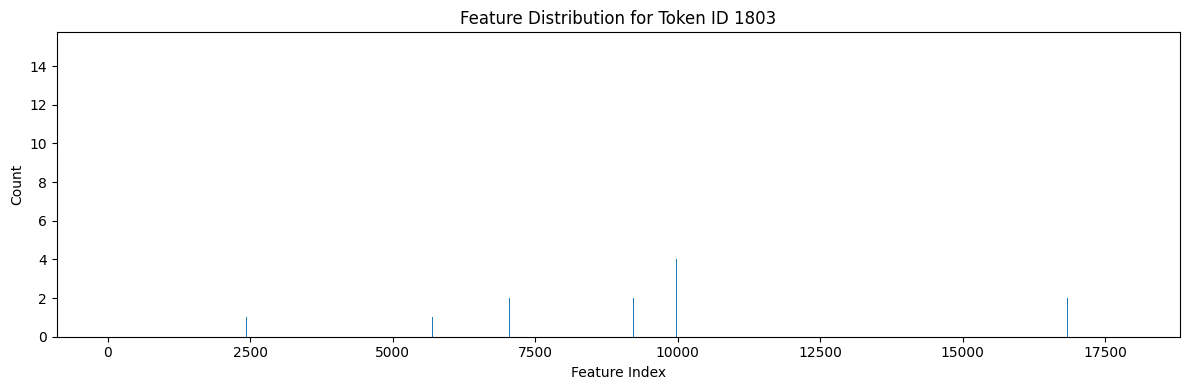

In [10]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

def plot_token_feature_distribution(token_feature_count, token_id):

    if token_id not in token_feature_count:
        print(f"Token ID {token_id} doesn't exsit in dataset。")
        return

    feature_distribution = token_feature_count[token_id]

    plt.figure(figsize=(12, 4))
    plt.bar(range(len(feature_distribution)), feature_distribution)
    plt.title(f"Feature Distribution for Token ID {token_id}")
    plt.xlabel("Feature Index")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("activated_features_car.png", dpi=600)
    plt.show()

model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
token_id = tokenizer(" car", return_tensors="pt")["input_ids"].numpy().tolist()[0][0]
print(f"{'car'}: {token_id}")

with open('./data/token_feature_count.json', 'r', encoding='utf-8') as f:
    token_feature_count = json.load(f)
plot_token_feature_distribution(token_feature_count, str(token_id))
